# Classifying Risky P2P Loans

## Abstract
The prevalence of a global Peer-to-Peer (P2P) economy, coupled with the recent deregulation of financial markets, has lead to the widespread adoption of Artificial Intelligence driven by FinTech firms to manage risk when speculating on unsecured P2P debt obligations. After meticulously identifying ‘debt belonging to high-risk individuals’ by leveraging an ensemble of Machine Learning algorithms, these firms are able to find ideal trading opportunities.

While researching AI-driven portfolio management that favor risk-minimization strategies by unmasking subtle interactions amongst high dimensional features to identify prospective trades that exhibit modest ,low-risk gains, I was impressed that the overall portfolio: realized a modest return through a numerosity of individual gains; achieved an impressive Sharpe ratio stemming from infrequent losses and minimal portfolio volatility.

# Project Overview

## Objective
Build a binary classification model that predicts the "Charged Off" or "Fully Paid" Status of a loan by analyzing predominant characteristics which differentiate the two classes in order to engineer new features that may better enable our Machine Learning algorithms to reach efficacy in minimizing portfolio risk while observing better-than-average returns. Ultimately, the aim is to deploy this model to assist in placing trades on loans immediately after they are issued by Lending Club.

### About P2P Lending

Peer-to-Peer (P2P) lending offers borrowers with bad credit to get the necessary funds to meet emergency deadlines. It might seem careless to lend even more money to people who have demonstrated an inability to repay loans in the past. However, by implementing Machine Learning algorithms to classify poor trade prospects, one can effectively minimize portfolio risk.

There is a large social component to P2P lending, for sociological factors (stigma of defaulting) often plays a greater role than financial metrics in determining an applicant’s creditworthiness. For example the “online friendships of borrowers act as signals of credit quality.” ( Lin et all, 2012)  

The social benefit of providing finance for another individual has wonderful implications, and, while it is nice to engage in philanthropic activities, the motivating factor for underwriting speculating in p2p lending markets is financial gain, especially since the underlying debt is unsecured and investors are liable to defaults.

## Project Setup

### Import Libraries & Modules

In [98]:
from IPython.display import display
from IPython.core.display import HTML

import warnings
warnings.filterwarnings('ignore')

import os
if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('../')

In [99]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_profiling

In [100]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# written by Gilles Louppe and distributed under the BSD 3 clause
from src.vn_datasci.blagging import BlaggingClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

# self-authored library that to facilatate ML classification and evaluation
from src.vn_datasci.skhelper import LearningModel, eval_db

### Notebook Config

In [101]:
from IPython.display import display
from IPython.core.display import HTML

import warnings
warnings.filterwarnings('ignore')

import os
if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('../')

In [102]:
%matplotlib inline
#%config figure_format='retina'
plt.rcParams.update({'figure.figsize': (10, 7)})

sns.set_context("notebook", font_scale=1.75, rc={"lines.linewidth": 1.25})
sns.set_style("darkgrid")
sns.set_palette("deep")

pd.options.display.width = 80
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50

# Data Preprocessing

## Load Dataset

Data used for this project comes directly from Lending Club’s historical loan records (the full record contains more than 100 columns).

In [103]:
def load_dataset(path='data/raw/lc_historical.csv'):
    lc = pd.read_csv(path, index_col='id', memory_map=True, low_memory=False)
    lc.loan_status = pd.Categorical(lc.loan_status, categories=['Fully Paid', 'Charged Off'])
    return lc

In [104]:
dataset = load_dataset()

## Exploration

### Summary

- <b>Target:</b> loan-status
- <b>Number of features:</b> 18 
- <b>Number of observations:</b> 138196 
- <b>Feature datatypes:</b> 
     + object: dti, bc_util, fico_range_low, percent_bc_gt_75, acc_open_past_24mths, annual_inc, recoveries, avg_cur_bal, loan_amnt
     + <i>float64</i>: revol_util, earliest_cr_line, purpose, emp_length, home_ownership, addr_state, issue_d, loan_status
- <b>Features with ALL missing or null values:</b>
     + inq_last_12m
     + all_util
- <b>Features with SOME missing or null values:</b>
     + avg_cur_bal (30%) 
     + bc_util (21%) 
     + percent_bc_gt_75 (21%) 
     + acc_open_past_24mths (20%) 
     + emp_length (0.18%) 
     + revol_util (0.08%) 

### Missing Data

#### Helper Functions

In [105]:
def calc_incomplete_stats(dataset):
    warnings.filterwarnings("ignore", 'This pattern has match groups')
    missing_data = pd.DataFrame(index=dataset.columns)
    missing_data['Null'] = dataset.isnull().sum()
    missing_data['NA_or_Missing'] = (
        dataset.apply(lambda col: (
            col.str.contains('(^$|n/a|^na$|^%$)', case=False).sum()))
        .fillna(0).astype(int))
    missing_data['Incomplete'] = (
        (missing_data.Null + missing_data.NA_or_Missing) / len(dataset))
    incomplete_stats = ((missing_data[(missing_data > 0).any(axis=1)])
                        .sort_values('Incomplete', ascending=False))
    return incomplete_stats

def display_incomplete_stats(incomplete_stats):
    stats = incomplete_stats.copy()
    df_incomplete = (
        stats.style
        .set_caption('Missing')
        .background_gradient(cmap=sns.light_palette("orange", as_cmap=True),
                             low=0, high=1, subset=['Null', 'NA_or_Missing'])
        .background_gradient(cmap=sns.light_palette("red", as_cmap=True),
                             low=0, high=.6, subset=['Incomplete'])
        .format({'Null': '{:,}', 'NA_or_Missing': '{:,}', 'Incomplete': '{:.1%}'}))
    display(df_incomplete)
    
def plot_incomplete_stats(incomplete_stats, ylim_range=(0, 100)):
    stats = incomplete_stats.copy()
    stats.Incomplete = stats.Incomplete * 100
    _ = sns.barplot(x=stats.index.tolist(), y=stats.Incomplete.tolist())
    for item in _.get_xticklabels():
        item.set_rotation(45)
    _.set(xlabel='Feature', ylabel='Incomplete (%)', 
          title='Features with Missing or Null Values',
          ylim=ylim_range)
    plt.show()
    
def incomplete_data_report(dataset, display_stats=True, plot=True):
    incomplete_stats = calc_incomplete_stats(dataset)
    if display_stats:
        display_incomplete_stats(incomplete_stats)
    if plot:
        plot_incomplete_stats(incomplete_stats)


incomplete_stats = load_dataset().pipe(calc_incomplete_stats)

In [106]:
display(incomplete_stats)

,Null,NA_or_Missing,Incomplete
all_util,172745,0,1.000000
inq_last_12m,172745,0,1.000000
avg_cur_bal,51649,0,0.298990
bc_util,36407,0,0.210756
percent_bc_gt_75,36346,0,0.210403
acc_open_past_24mths,35121,0,0.203311
emp_length,0,7507,0.043457
revol_util,144,0,0.000834


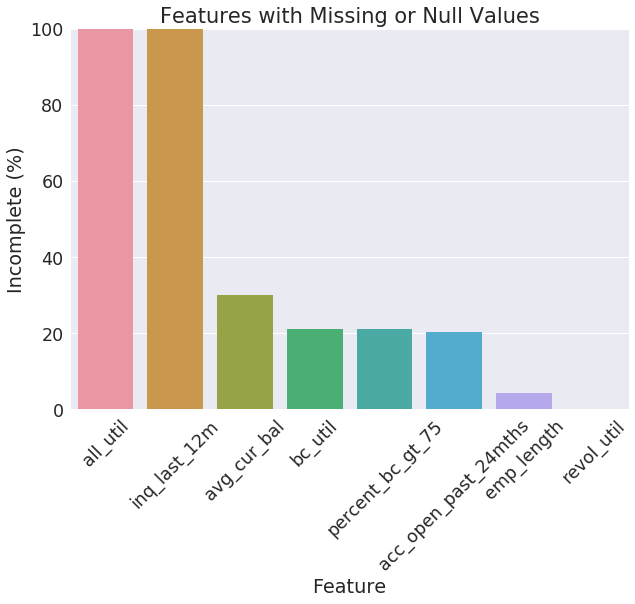

In [107]:
plot_incomplete_stats(incomplete_stats)

## Data Munging

### Cleaning

- all_util, inq_last_12m
    + Drop features (all observations contain null/missing values)
- revol_util
    1. Remove the percent sign (%) from string
    2. Convert to a float
- earliest_cr_line, issue_d
    + Convert to datetime data type.
- emp_length
    1. Strip leading and trailing whitespace
    2. Replace '< 1' with '0.5'
    3. Replace '10+' with '10.5'
    4. Fill null values with '-1.5'
    5. Convert to float

In [108]:
def clean_data(lc):
    lc = lc.copy().dropna(axis=1, thresh=1)
    
    dt_features = ['earliest_cr_line', 'issue_d']
    lc[dt_features] = lc[dt_features].apply(
        lambda col: pd.to_datetime(col, format='%Y-%m-%d'), axis=0)
    
    cat_features =['purpose', 'home_ownership', 'addr_state']
    lc[cat_features] = lc[cat_features].apply(pd.Categorical, axis=0)
    
    lc.revol_util = (lc.revol_util
                     .str.extract('(\d+\.?\d?)', expand=False)
                     .astype('float'))
    
    lc.emp_length = (lc.emp_length
                     .str.extract('(< 1|10\+|\d+)', expand=False)
                     .replace('< 1', '0.5')
                     .replace('10+', '10.5')
                     .fillna('-1.5')
                     .astype('float'))
    return lc

In [109]:
dataset = load_dataset().pipe(clean_data)

## Feature Engineering

### New Features

- loan_amnt_to_inc
    + the ratio of loan amount to annual income
- earliest_cr_line_age
    + age of first credit line from when the loan was issued
- avg_cur_bal_to_inc
    + the ratio of avg current balance to annual income
- avg_cur_bal_to_loan_amnt
    + the ratio of avg current balance to loan amount
- acc_open_past_24mths_groups
    + level of accounts opened in the last 2 yrs

In [110]:
def add_features(lc):
    # ratio of loan amount to annual income
    group_labels = ['low', 'avg', 'high']
    lc['loan_amnt_to_inc'] = (
        pd.cut((lc.loan_amnt / lc.annual_inc), 3, labels=['low', 'avg', 'high'])
        .cat.set_categories(['low', 'avg', 'high'], ordered=True))
    
    # age of first credit line from when the loan was issued
    lc['earliest_cr_line_age'] = (lc.issue_d - lc.earliest_cr_line).astype(int)
    
    # the ratio of avg current balance to annual income
    lc['avg_cur_bal_to_inc'] = lc.avg_cur_bal / lc.annual_inc
    
    # the ratio of avg current balance to loan amount
    lc['avg_cur_bal_to_loan_amnt'] = lc.avg_cur_bal / lc.loan_amnt
    
    # grouping level of accounts opened in the last 2 yrs
    lc['acc_open_past_24mths_groups'] = (
        pd.qcut(lc.acc_open_past_24mths, 3, labels=['low', 'avg', 'high'])
        .cat.add_categories(['unknown']).fillna('unknown')
        .cat.set_categories(['low', 'avg', 'high', 'unknown'], ordered=True))
    
    return lc

In [111]:
dataset = load_dataset().pipe(clean_data).pipe(add_features)

### Drop Features

In [112]:
def drop_features(lc):
    target_leaks = ['recoveries', 'issue_d']
    other_features = ['earliest_cr_line', 'acc_open_past_24mths', 'addr_state']
    to_drop = target_leaks + other_features
    return lc.drop(to_drop, axis=1)

In [113]:
dataset = load_dataset().pipe(clean_data).pipe(add_features).pipe(drop_features)

## Load & Prepare Function

In [114]:
def load_and_preprocess_data():
    return (load_dataset()
            .pipe(clean_data)
            .pipe(add_features)
            .pipe(drop_features))

# Exploratory Data Analysis (EDA)

## Helper Functions

In [115]:
def plot_factor_pct(dataset, feature):
    if feature not in dataset.columns:
        return
    y = dataset[feature]
    factor_counts = y.value_counts()
    x_vals = factor_counts.index.tolist()
    y_vals = ((factor_counts.values/factor_counts.values.sum())*100).round(2)
    sns.barplot(y=x_vals, x=y_vals);

def plot_pct_charged_off(lc, feature):
    lc_counts = lc[feature].value_counts()
    charged_off = lc[lc.loan_status=='Charged Off']
    charged_off_counts = charged_off[feature].value_counts()
    charged_off_ratio = ((charged_off_counts / lc_counts * 100)
                         .round(2).sort_values(ascending=False))

    x_vals = charged_off_ratio.index.tolist()
    y_vals = charged_off_ratio
    sns.barplot(y=x_vals, x=y_vals);

## Overview

### Missing Data

In [116]:
processed_dataset = load_and_preprocess_data()
incomplete_stats = calc_incomplete_stats(processed_dataset)

In [117]:
display(incomplete_stats)

,Null,NA_or_Missing,Incomplete
avg_cur_bal,51649,0,0.298990
avg_cur_bal_to_inc,51649,0,0.298990
avg_cur_bal_to_loan_amnt,51649,0,0.298990
bc_util,36407,0,0.210756
percent_bc_gt_75,36346,0,0.210403
revol_util,144,0,0.000834


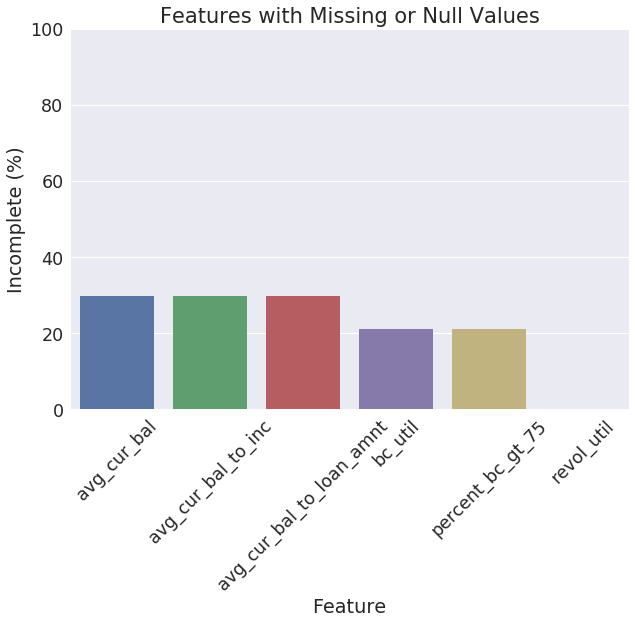

In [118]:
plot_incomplete_stats(incomplete_stats)

## Factor Analysis

### Target: loan_status

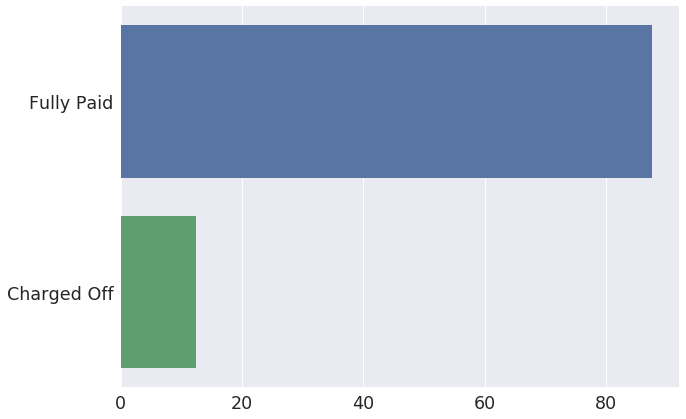

In [119]:
processed_dataset.pipe(plot_factor_pct, 'loan_status')

## Summary Statistics

In [120]:
HTML(processed_dataset.pipe(pandas_profiling.ProfileReport).html)

Number of variables,18
Number of observations,172745
Total Missing (%),7.3%
Total size in memory,18.0 MiB
Average record size in memory,109.0 B
Numeric,13
Categorical,5
Date,0
Text (Unique),0
Rejected,0
Distinct count,4


# Predictive Modeling

In [121]:
def to_xy(dataset):
    y = dataset.pop('loan_status').cat.codes
    X = pd.get_dummies(dataset, drop_first=True)
    return X, y

## Initializing Train/Test Sets

### Shuffle and Split Data

Let's split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [122]:
X, y = load_and_preprocess_data().pipe(to_xy)

split_data = train_test_split(X, y, test_size=0.20, stratify=y, random_state=11)
X_train, X_test, y_train, y_test = split_data

train_test_sets = dict(
    zip(['X_train', 'X_test', 'y_train', 'y_test'], [*split_data]))

In [123]:
(pd.DataFrame(
    data={'Observations (#)': [X_train.shape[0], X_test.shape[0]],
          'Percent (%)': ['80%', '20%'],
          'Features (#)': [X_train.shape[1], X_test.shape[1]]},
    index=['Training', 'Test'])
 [['Percent (%)', 'Features (#)', 'Observations (#)']])

,Percent (%),Features (#),Observations (#)
Training,80%,34,138196
Test,20%,34,34549


## Classification Models

### Naive Predictor (Baseline)

In [124]:
dummy_model = LearningModel(
    'Naive Predictor - Baseline', Pipeline([
        ('imp', Imputer(strategy='median')), 
        ('clf', DummyClassifier(strategy='constant', constant=0))]))

dummy_model.fit_and_predict(**train_test_sets)

model_evals = eval_db(dummy_model.eval_report)

### Decision Tree Classifier

,FitTime,Accuracy,FBeta,F1,AUC
Decision Tree Classifier,2.0,0.78558,0.156742,0.154531,0.516244


             precision    recall  f1-score   support

          0       0.88      0.87      0.88     30271
          1       0.15      0.16      0.15      4278

avg / total       0.79      0.79      0.79     34549



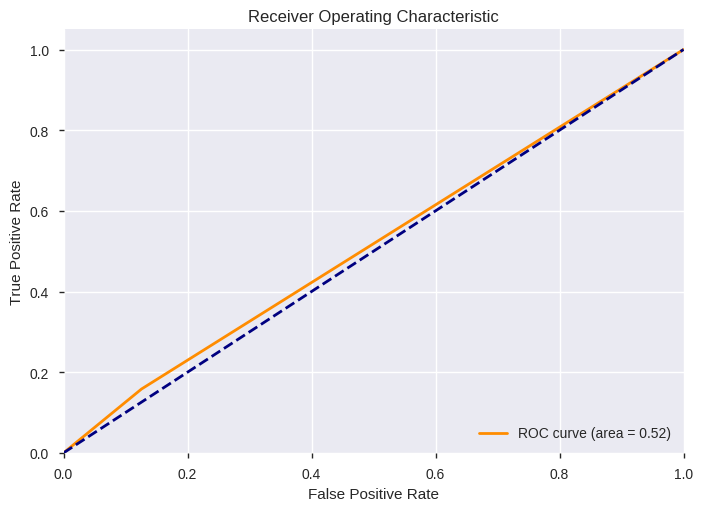

In [125]:
tree_model = LearningModel(
    'Decision Tree Classifier', Pipeline([
        ('imp', Imputer(strategy='median')), 
        ('clf', DecisionTreeClassifier(class_weight='balanced', random_state=11))]))

tree_model.fit_and_predict(**train_test_sets)
tree_model.display_evaluation()

model_evals = eval_db(model_evals, tree_model.eval_report)

### Random Forest Classifier

,FitTime,Accuracy,FBeta,F1,AUC
Random Forest Classifier,2.0,0.874671,0.008998,0.014117,0.573608


             precision    recall  f1-score   support

          0       0.88      1.00      0.93     30271
          1       0.27      0.01      0.01      4278

avg / total       0.80      0.87      0.82     34549



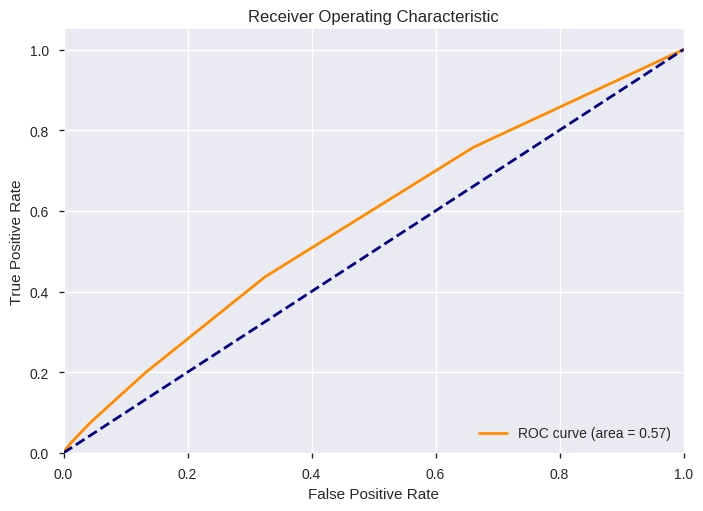

In [126]:
rf_model = LearningModel(
    'Random Forest Classifier', Pipeline([
        ('imp', Imputer(strategy='median')), 
        ('clf', RandomForestClassifier(
            class_weight='balanced_subsample', random_state=11))]))

rf_model.fit_and_predict(**train_test_sets)
rf_model.display_evaluation()

model_evals = eval_db(model_evals, rf_model.eval_report)

### Blagging Classifier

#### Base Estimator -> RF

,FitTime,Accuracy,FBeta,F1,AUC
Blagging Classifier (RF),2.0,0.719181,0.344518,0.270746,0.645877


             precision    recall  f1-score   support

          0       0.90      0.76      0.83     30271
          1       0.20      0.42      0.27      4278

avg / total       0.82      0.72      0.76     34549



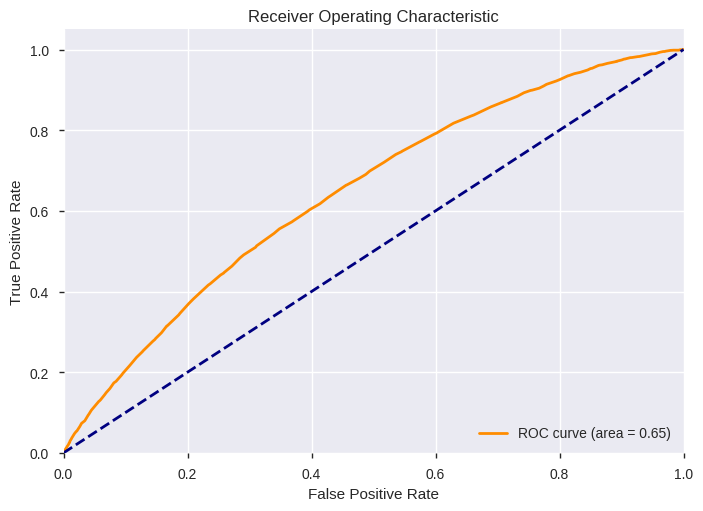

In [127]:
blagging_pipeline = Pipeline([
    ('imp', Imputer(strategy='median')), 
    ('clf', BlaggingClassifier(
        random_state=11, n_jobs=-1,
        base_estimator=RandomForestClassifier(
            class_weight='balanced_subsample', random_state=11)))])

blagging_model = LearningModel('Blagging Classifier (RF)', blagging_pipeline)

blagging_model.fit_and_predict(**train_test_sets)
blagging_model.display_evaluation()

model_evals = eval_db(model_evals, blagging_model.eval_report)

#### Base Estimator -> ExtraTrees

,FitTime,Accuracy,FBeta,F1,AUC
Blagging Classifier (Extra Trees),19.0,0.749718,0.309224,0.259611,0.645899


             precision    recall  f1-score   support

          0       0.90      0.81      0.85     30271
          1       0.20      0.35      0.26      4278

avg / total       0.81      0.75      0.78     34549



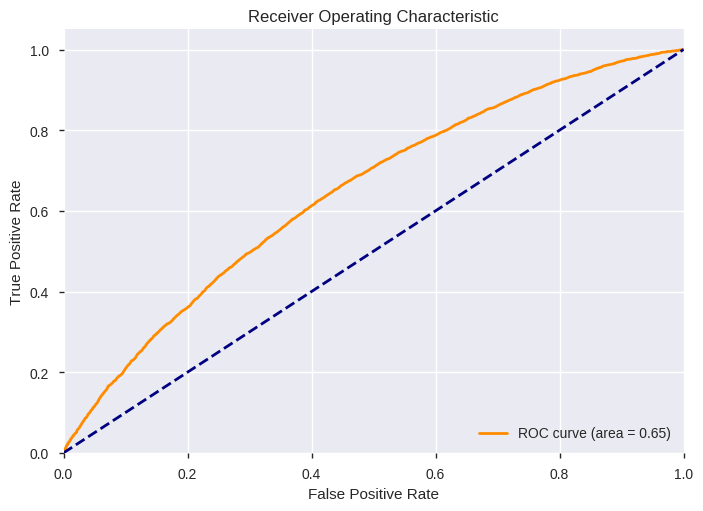

In [128]:
blagging_clf = BlaggingClassifier(
    random_state=11, n_jobs=-1,
    base_estimator=ExtraTreesClassifier(
        criterion='entropy', class_weight='balanced_subsample', 
        max_features=None, n_estimators=60, random_state=11))

blagging_model = LearningModel(
    'Blagging Classifier (Extra Trees)', Pipeline([
        ('imp', Imputer(strategy='median')), 
        ('clf', blagging_clf)]))

blagging_model.fit_and_predict(**train_test_sets)
blagging_model.display_evaluation()

model_evals = eval_db(model_evals, blagging_model.eval_report)

## Evaluating Model Performance 

### Feature Importance (via RandomForestClassifier)

In [129]:
rf_top_features = LearningModel('Random Forest Classifier',
    Pipeline([('imp', Imputer(strategy='median')), 
              ('clf', RandomForestClassifier(max_features=None,
                  class_weight='balanced_subsample', random_state=11))]))
                  
rf_top_features.fit_and_predict(**train_test_sets)

In [130]:
rf_top_features.display_top_features(top_n=15)

,Feature,Score
1,dti,0.115602
2,earliest_cr_line_age,0.115381
3,revol_util,0.109714
4,annual_inc,0.099535
5,loan_amnt,0.080153
6,bc_util,0.077465
7,fico_range_low,0.071342
8,avg_cur_bal_to_loan_amnt,0.062594
9,avg_cur_bal_to_inc,0.052817
10,avg_cur_bal,0.050275


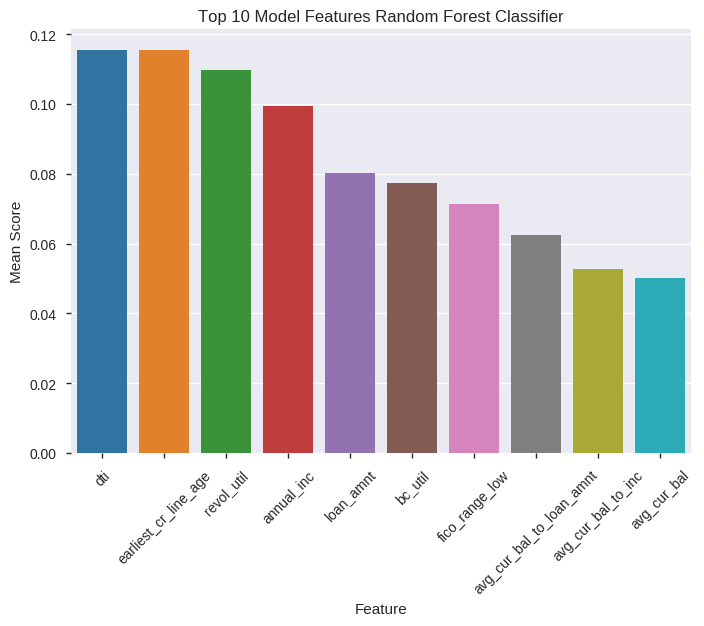

In [131]:
rf_top_features.plot_top_features(top_n=10)

## Model Selection

### Comparative Analysis

In [132]:
display(model_evals)

,FitTime,Accuracy,FBeta,F1,AUC
Naive Predictor - Baseline,0.0,0.876176,0.000000,0.000000,0.500000
Decision Tree Classifier,2.0,0.785580,0.156742,0.154531,0.516244
Random Forest Classifier,2.0,0.874671,0.008998,0.014117,0.573608
Blagging Classifier (RF),2.0,0.719181,0.344518,0.270746,0.645877
Blagging Classifier (Extra Trees),19.0,0.749718,0.309224,0.259611,0.645899


### Optimal Model

In [133]:
blagging_model = LearningModel('Blagging Classifier (Extra Trees)', 
    Pipeline([('imp', Imputer(strategy='median')), 
              ('clf', BlaggingClassifier(
                  base_estimator=ExtraTreesClassifier(
                      criterion='entropy', class_weight='balanced_subsample', 
                      max_features=None, n_estimators=60, random_state=11), 
                  random_state=11, n_jobs=-1))]))

blagging_model.fit_and_predict(**train_test_sets)

### Optimizing Hyperparameters
#### ToDo: Perform GridSearch...
#### Results:

In [134]:
(pd.DataFrame(data={'Benchmark Predictor': [0.7899, 0.1603, 0.5203],
                   'Unoptimized Model': [0.7499, 0.2602, 0.6463],
                   'Optimized Model': ['', '', '']}, 
             index=['Accuracy Score', 'F1-score', 'AUC'])
 [['Benchmark Predictor', 'Unoptimized Model', 'Optimized Model']])

,Benchmark Predictor,Unoptimized Model,Optimized Model
Accuracy Score,0.7899,0.7499,
F1-score,0.1603,0.2602,
AUC,0.5203,0.6463,


# Conclusion *Pending

# References

